In [3]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import os
import datetime as dt
import numpy as np
import pandas as pd

# Data handling
import pwlf
import xarray as xr

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Geospatial plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Copernicus Marine API (e.g., motuclient or copernicusmarine)
import copernicusmarine  # Ensure this is installed and authenticated

In [4]:
# Temporal coverage of downloade data
StartDate = '1993-01-01T00:00:00'  # Download data from
EndDate   = '2022-12-31T23:59:59'  # Up to 2024-06-13

# Area of study
MinLat = 9.39
MaxLat = 10.40
MinLon = 75.59
MaxLon = 76.40

# File names
DataPath = 'data' # Storing directory
SatFileName = 'Data_SSH_SAT.nc'

In [ ]:
## Login to Copernicus Marine
copernicusmarine.login()

In [ ]:
## Download from Copernicus Marine
copernicusmarine.subset(dataset_id = 'c3s_obs-sl_glo_phy-ssh_my_twosat-l4-duacs-0.25deg_P1D',
                        variables = ['sla'],
                        minimum_longitude = MinLon,
                        maximum_longitude = MaxLon,
                        minimum_latitude = MinLat,
                        maximum_latitude = MaxLat,
                        start_datetime = StartDate,
                        end_datetime = EndDate,
                        output_filename = SatFileName,
                        output_directory = DataPath)

In [121]:
# Open Satellite datafile
File2Open = '{}/{}'.format(DataPath, SatFileName)
SatDS = xr.open_dataset(File2Open)

# Print info
display(SatDS)

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 10957, latitude: 4, longitude: 4)
Coordinates:
  * latitude   (latitude) float32 16B 9.625 9.875 10.12 10.38
  * longitude  (longitude) float32 16B 75.62 75.88 76.12 76.38
  * time       (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31
Data variables:
    sla        (time, latitude, longitude) float64 1MB ...
Attributes:
    source:                    Altimetry measurements
    institution:               CLS, CNES
    history:                   2024/09/23 20:26:01 pva_axp@trex014.sis.cnes.f...
    title:                     DT merged two satellites Global Ocean Gridded ...
    Conventions:               CF-1.6
    contact:                   http://climate.copernicus.eu/c3s-user-service-...
    references:                http://climate.copernicus.eu
    comment:                   Sea Surface Height measured by Altimetry and d...
    copernicusmarine_version:  2.0.1

In [ ]:
#dictionary
TimeSeriesDates = {'kochi' : ['2018-01-01', '2018-01-01']
                   }
dataRange = 'kochi'

DateIni = TimeSeriesDates[dataRange][0]
DateEnd = TimeSeriesDates[dataRange][1]

print("Date Range:", DateIni, "to", DateEnd)
print("Satellite Data Range:", SatDS.time.min().values, "to", SatDS.time.max().values)

# Subseting a especific variable from the dataset DS
SatData2Map = SatDS.sel(time = slice(DateIni, DateEnd)).max(dim = 'time')
# Print result
display(SatData2Map)

## Plot Map
def PlotMap(Data, Title):
    '''
    This function compiles the code lines needed to plot a map
    '''
    #1. Figure Creation
    Fig = plt.figure(figsize=(10, 7))             # create new figure
    Ax = plt.axes(projection=ccrs.PlateCarree()) # create axes with the map projection
    
    #2. Editing basic map features
    Ax.coastlines()                                                           # add the coastlines
    G = Ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle=':') # add the longitude / latitude lines
    G.right_labels = False                                                    # remove latitude labels on the right
    G.top_labels = False                                                      # remove longitude labels on the top
    G.xlabel_style = {'size': 'small'}                                        # x-axis label properties
    G.ylabel_style = {'size': 'small'}                                        # y-axis label properties
    Ax.add_feature(cfeature.LAND, zorder=0, edgecolor='k')                    # add land mask
    Ax.add_feature(cfeature.BORDERS, linestyle=':')                           # add country borders
    
    #3. Command to plot the data
    Map = Ax.pcolor(Data['longitude'],                  # Longitude data
                    Data['latitude'],                   # Latitude data
                    Data)                               # Values to plot

    #4. Final editing commands
    Ax.set_title(Title, fontsize=15, fontweight="bold")     # add a title to the figure
    CBar = plt.colorbar(Map, ax=Ax)                         # add the colorbar
    CBar.ax.tick_params(labelsize='small')                  # format ticks
    CBar.set_label(label='m', fontsize='small')             # format colorbar
    return Fig, Ax

# Geographic coordinates selection [lat, Lon]
AnalysisLoc = {'kochi': [9.98, 76.26]}

dataRange = 'kochi'  # ✅ Set the correct key
SelLat = AnalysisLoc[dataRange][0]
SelLon = AnalysisLoc[dataRange][1]

# Plot Satellite Data
MapTitle = 'Sea Surface Anomaly kochi {} (Satellite)'.format(dataRange)
Fig, SatAx = PlotMap(SatData2Map['sla'], MapTitle)

# Subseting a especific variable from the dataset DS
SatTS = SatDS.sel(latitude = SelLat,
                  longitude = SelLon,
                  method = 'nearest').squeeze()
# Print result
display(SatTS)

## Plot Time Series

#1. Figure creation
Fig = plt.figure(figsize=(15, 5))            # create new figure
Ax = plt.axes()                                    # create axes

#2. Commands to plot the data
plt.plot(SatTS['time'], SatTS['sla'], label='Satellite', color='blue')

#4. Final editing commands
Title = 'Time Series at Lat={} Lon={}'.format(SelLat, SelLon)
Ax.set_title(Title, fontsize=15, fontweight="bold")     # add a title to the figure
plt.xlabel('Time (Yr)')                                 # x-axis label properties
plt.ylabel('SSH (m)')                                   # y-axis label properties
Ax.legend()                                             # add legend in the figure

YrLoc = mdt.YearLocator()
Ax.xaxis.set_major_locator(YrLoc)                       # Define months for mayor ticks
DateFmt = mdt.DateFormatter('%Y')
Ax.xaxis.set_major_formatter(DateFmt)                   # Format labels in X-axis ticks
MthLoc = mdt.MonthLocator()
Ax.xaxis.set_minor_locator(MthLoc)                      # Define days for minor ticks

plt.grid(axis='x', linestyle=':')   

In [5]:
"""OUR ANALYSIS USING SATELLITE ALTIMETRY DATA STARTS HERE"""
# Open Satellite datafile
File2Open = '{}/{}'.format(DataPath, SatFileName)
SatDS = xr.open_dataset(File2Open)

# Print info
display(SatDS)

# Step 1: create dataframe
sla_point = SatDS['sla'].sel(latitude=9.98, longitude=76.26, method='nearest')
df_point = sla_point.to_dataframe().reset_index()

# Step 2: Take spatial average (mean over latitude and longitude)
sla_mean_ts = SatDS['sla'].mean(dim=['latitude', 'longitude'])

# Step 3: Convert to DataFrame and reset index
df_sla = sla_mean_ts.to_dataframe().reset_index()

# Step 4: Optional — convert 'time' to first of month if needed
df_sla['time'] = pd.to_datetime(df_sla['time']).dt.to_period('M').dt.to_timestamp()

# Step 5: Optional — sort values just in case
df_sla = df_sla.sort_values('time').reset_index(drop=True)

# Now it's in the format you want
print(df_sla.head())

# Step 1: Ensure time is in datetime format
df_sla['time'] = pd.to_datetime(df_sla['time'])

# Step 2: Extract Month name and Year
df_sla['Month'] = df_sla['time'].dt.month_name()
df_sla['Year'] = df_sla['time'].dt.year

# Step 3: Create Year-Month column to match tide gauge format
df_sla['Year-Month'] = df_sla['Year'].astype(str) + ' ' + df_sla['Month']

# Step 4: View or save result
print(df_sla[['time', 'sla', 'Month', 'Year', 'Year-Month']].head())

# Optional: Save to CSV if needed
# df_sla.to_csv('formatted_satellite_sla.csv', index=False)

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 10957, latitude: 4, longitude: 4)
Coordinates:
  * latitude   (latitude) float32 16B 9.625 9.875 10.12 10.38
  * longitude  (longitude) float32 16B 75.62 75.88 76.12 76.38
  * time       (time) datetime64[ns] 88kB 1993-01-01 1993-01-02 ... 2022-12-31
Data variables:
    sla        (time, latitude, longitude) float64 1MB ...
Attributes:
    source:                    Altimetry measurements
    institution:               CLS, CNES
    history:                   2024/09/23 20:26:01 pva_axp@trex014.sis.cnes.f...
    title:                     DT merged two satellites Global Ocean Gridded ...
    Conventions:               CF-1.6
    contact:                   http://climate.copernicus.eu/c3s-user-service-...
    references:                http://climate.copernicus.eu
    comment:                   Sea Surface Height measured by Altimetry and d...
    copernicusmarine_version:  2.0.1

        time       sla
0 1993-01-01  0.128414
1 1993-01-01  0.048943
2 1993-01-01  0.043286
3 1993-01-01  0.046193
4 1993-01-01  0.044836
        time       sla    Month  Year    Year-Month
0 1993-01-01  0.128414  January  1993  1993 January
1 1993-01-01  0.048943  January  1993  1993 January
2 1993-01-01  0.043286  January  1993  1993 January
3 1993-01-01  0.046193  January  1993  1993 January
4 1993-01-01  0.044836  January  1993  1993 January


In [6]:
# OPTIONAL STEP: Take monthly mean before further processing
df_sla['Month_Start'] = df_sla['time'].dt.to_period('M').dt.to_timestamp()
df_sla = df_sla.groupby('Month_Start')['sla'].mean().reset_index()
df_sla.rename(columns={'Month_Start': 'time'}, inplace=True)

# Convert SLA from meters to mm
df_sla['sla_mm'] = df_sla['sla'] * 1000

# Add time components
df_sla['time'] = pd.to_datetime(df_sla['time'])
df_sla['Month'] = df_sla['time'].dt.month_name()
df_sla['Year'] = df_sla['time'].dt.year
df_sla['Year-Month'] = pd.to_datetime(df_sla['Year'].astype(str) + '-' + df_sla['Month'], errors='coerce')

# Smooth the data using rolling average
df_sla['smoothed'] = df_sla['sla_mm'].rolling(window=12).mean()

# Remove NaNs
df_filtered = df_sla.dropna(subset=['Year-Month', 'smoothed'])
df_filtered = df_filtered[~df_filtered['smoothed'].isin([float('inf'), float('-inf')])]
df_sla['Year-Month-numeric'] = df_sla['Year-Month'].dt.strftime('%Y').astype(int)

# Linear regression
X = df_sla['Year-Month-numeric'].values.reshape(-1, 1)
y = df_sla['sla_mm'].values

linear_model = LinearRegression()
linear_model.fit(X, y)
linear_slope = linear_model.coef_[0]
linear_intercept = linear_model.intercept_
y_pred_linear = linear_model.predict(X)

# Plot
plt.figure(figsize=(15, 7), dpi=700)
sns.lineplot(data=df_sla, x='Year-Month', y='sla_mm', color='darkgrey', label='Mean Monthly SLA', linewidth=1.5)
sns.lineplot(data=df_filtered, x='Year-Month', y='smoothed', color='b', label='Smoothed SLA (12-mo Avg)', linewidth=2)
plt.plot(df_sla['Year-Month'], y_pred_linear, label=f'Linear Fit: {linear_slope:.2f} mm/year', color='orange')

# Axis formatting
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Sea Level Anomaly (mm)', fontsize=14)
plt.title('Monthly Sea Level Anomaly (Satellite) with Linear Regression Fit', fontsize=15)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Print linear regression slope
print(f"Linear Regression Slope: {linear_slope:.2f} mm/year")

Linear Regression Slope: 4.07 mm/year


**ANALYSIS USING TIDE GAUGE DATA**

Index(['time, years', 'height, mm', 'Month', 'Year', 'Year-Month'], dtype='object')
   time, years  height, mm     Month  Year     Year-Month
0    1940.0417      6874.0   January  1940   1940 January
1    1940.1250      6807.0  February  1940  1940 February
2    1940.2083      6733.0     March  1940     1940 March
3    1940.2917      6813.0     April  1940     1940 April
4    1940.3750      6794.0       May  1940       1940 May


Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1094 ticks ([-12450.0, ..., 20819.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting 

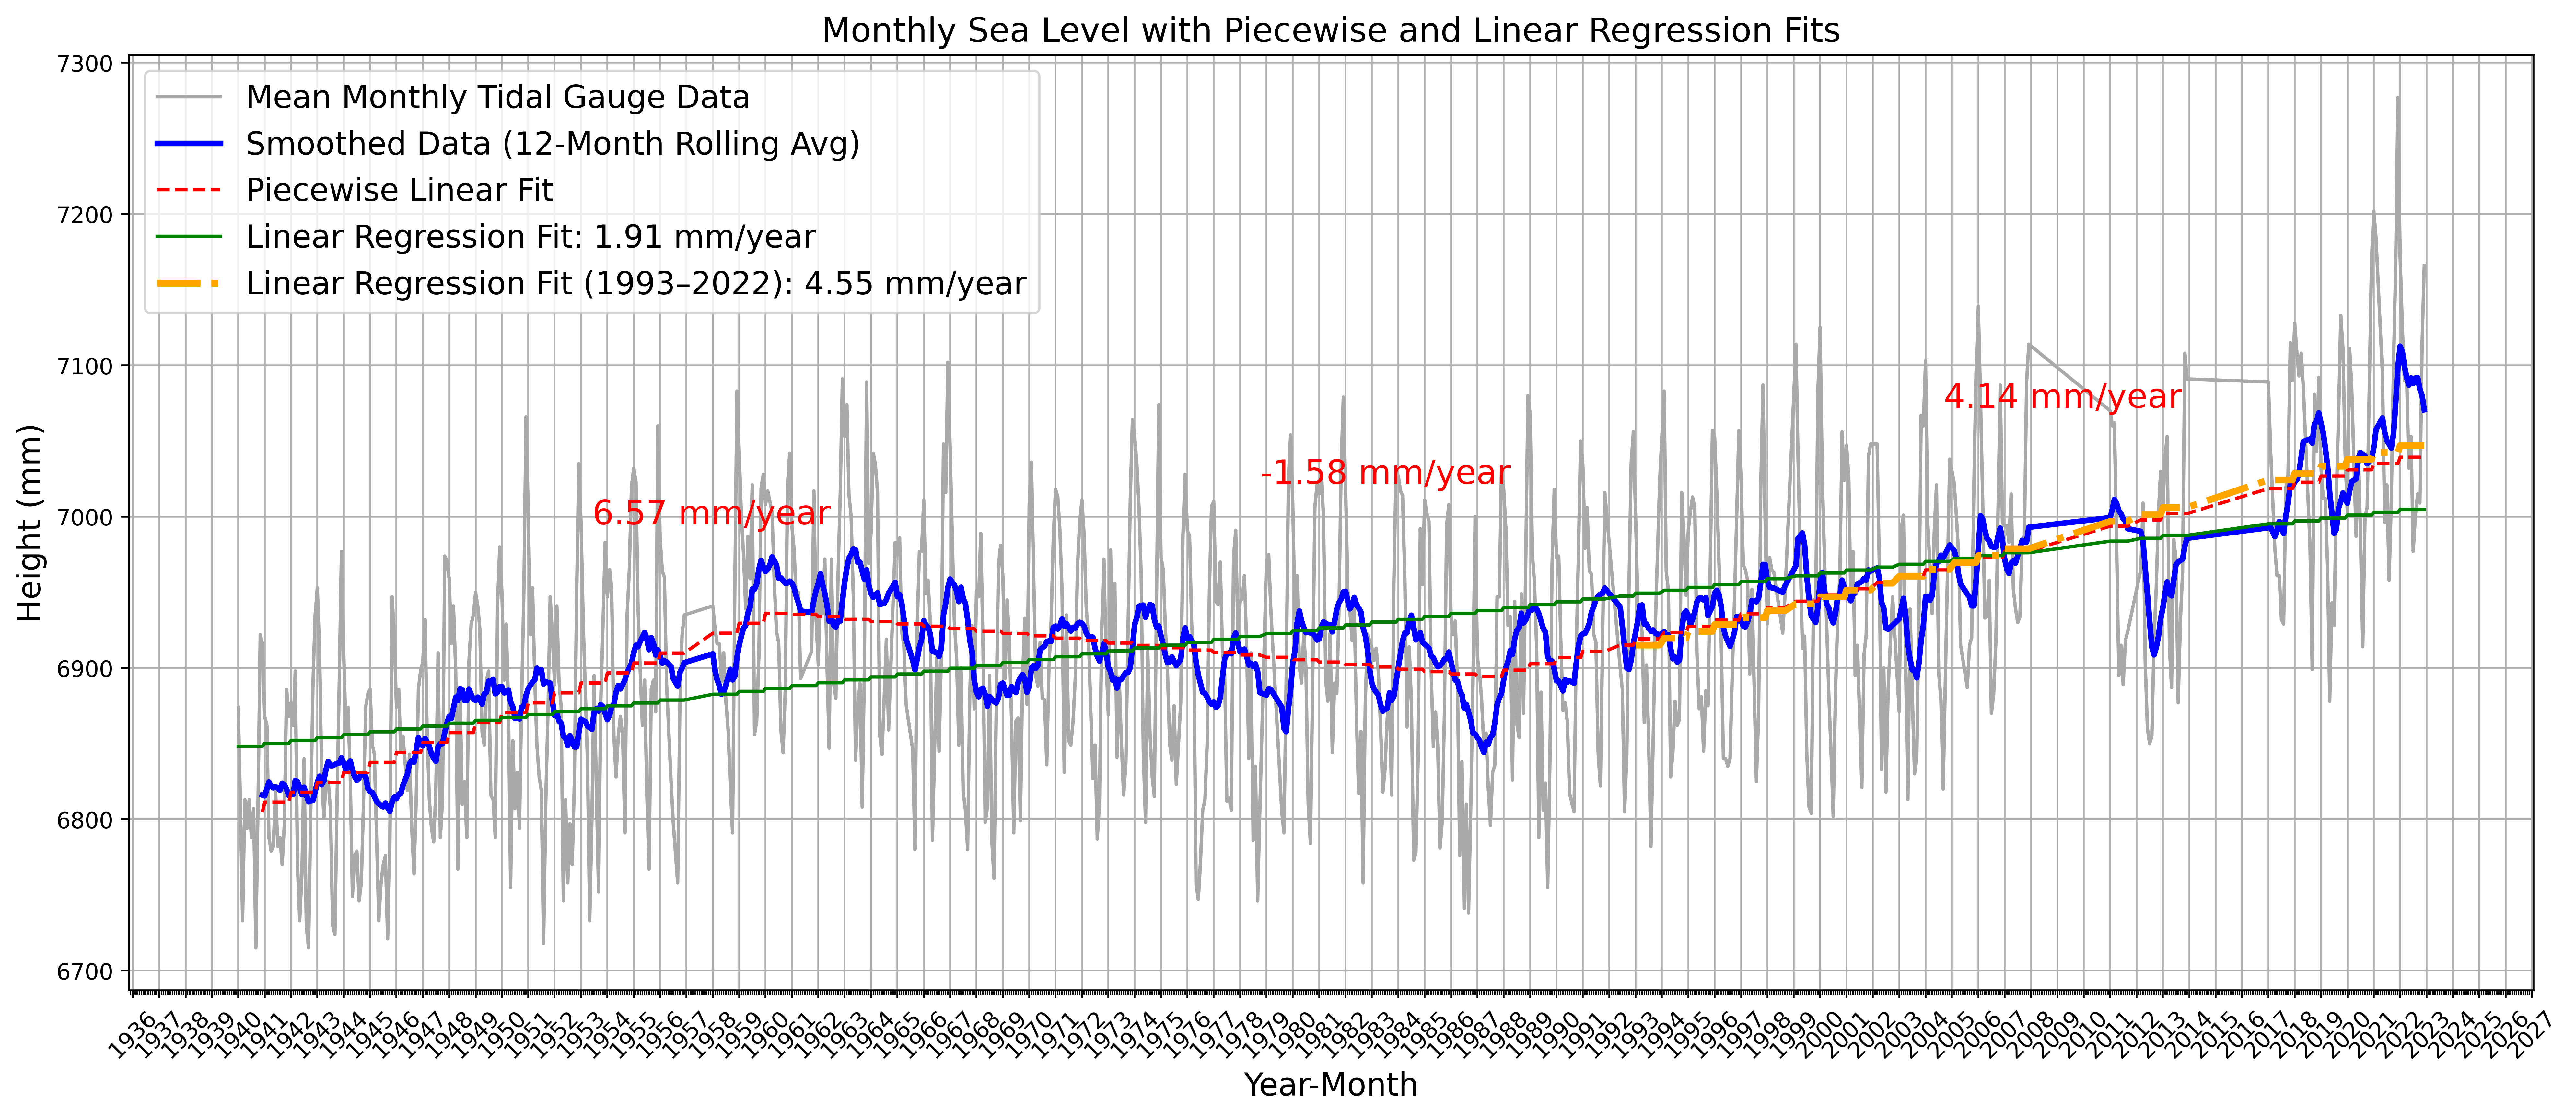

Piecewise Slope(s) (Rate of Change): [ 6.56816004 -1.57843323  4.13868064]
Linear Regression Slope (full period): 1.91 mm/year
Linear Regression Intercept: 3144.80 mm
Subset Linear Regression (1993–2022) Slope: 4.55 mm/year
Subset Linear Regression Intercept: -2147.89 mm


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pwlf
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load the updated DataFrame (after adding 'Month' column)
df = pd.read_csv(r"c:\Users\abhij\Desktop\PhD\2025\Kochi (Path-Desktop-Kochi)\Tidal_Data_Kochi\updated_data_with_year_month.csv")

# Step 1: Check the column names and data types
print(df.columns)
print(df.head())

# Step 2: Extract year from 'time, years' column
df['time, years'] = pd.to_numeric(df['time, years'], errors='coerce')
df['Year'] = df['time, years'].apply(lambda x: int(x) if pd.notna(x) else None)

# Step 3: Create 'Year-Month' column
df['Year-Month'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], errors='coerce')

# Step 4: Ensure 'height, mm' is numeric
df['height, mm'] = pd.to_numeric(df['height, mm'], errors='coerce')

# Step 5: Handle NaN values
df.dropna(subset=['Year-Month', 'height, mm'], inplace=True)

# Step 6: Smooth the data using a rolling window of 12 months
df['smoothed'] = df['height, mm'].rolling(window=12).mean()

# Step 7: Remove NaN and Inf from smoothed data
df_filtered = df.dropna(subset=['Year-Month', 'smoothed'])
df_filtered = df_filtered[~df_filtered['smoothed'].isin([float('inf'), float('-inf')])]

# Step 8: Convert dates to numeric format for regression
df_filtered['Year-Month-numeric'] = df_filtered['Year-Month'].dt.strftime('%Y').astype(int)

# Step 9: Apply Piecewise Linear Fit
model = pwlf.PiecewiseLinFit(df_filtered['Year-Month-numeric'], df_filtered['smoothed'])
breaks = model.fit(3)
x_fit = df_filtered['Year-Month-numeric']
y_fit = model.predict(x_fit)
slopes = model.calc_slopes()

# Step 10: Linear Regression (whole dataset)
df['Year-Month-numeric'] = df['Year-Month'].dt.strftime('%Y').astype(int)
X = df['Year-Month-numeric'].values.reshape(-1, 1)
y = df['height, mm'].values

linear_model = LinearRegression()
linear_model.fit(X, y)
linear_slope = linear_model.coef_[0]
linear_intercept = linear_model.intercept_
y_pred_linear = linear_model.predict(X)

# Step 11: Linear Regression for 1993–2022 subset
start_year = 1993
end_year = 2022
df_subset = df[(df['Year-Month-numeric'] >= start_year) & (df['Year-Month-numeric'] <= end_year)]
X_subset = df_subset['Year-Month-numeric'].values.reshape(-1, 1)
y_subset = df_subset['height, mm'].values

linear_model_subset = LinearRegression()
linear_model_subset.fit(X_subset, y_subset)
y_pred_subset = linear_model_subset.predict(X_subset)
subset_slope = linear_model_subset.coef_[0]
subset_intercept = linear_model_subset.intercept_

# Step 12: Plotting
plt.figure(figsize=(16, 7), dpi=500)

# Original data
sns.lineplot(data=df, x='Year-Month', y='height, mm', color='darkgrey', label='Mean Monthly Tidal Gauge Data', linewidth=1.5)

# Smoothed data
sns.lineplot(data=df_filtered, x='Year-Month', y='smoothed', color='b', label='Smoothed Data (12-Month Rolling Avg)', linewidth=2.5)

# Piecewise Fit
plt.plot(df_filtered['Year-Month'], y_fit, label='Piecewise Linear Fit', color='r', linestyle='--')

# Linear Regression Fit (whole period)
plt.plot(df['Year-Month'], y_pred_linear, label=f'Linear Regression Fit: {linear_slope:.2f} mm/year', color='g', linestyle='-')

# Linear Regression Fit (1993–2022)
plt.plot(df_subset['Year-Month'], y_pred_subset, label=f'Linear Regression Fit (1993–2022): {subset_slope:.2f} mm/year', color='orange', linestyle='-.', linewidth=3)

# Annotate Piecewise slopes
for i, slope in enumerate(slopes):
    mid_idx = (i * len(df_filtered) // len(slopes)) + len(df_filtered) // (2 * len(slopes))
    plt.annotate(f'{slope:.2f} mm/year',
                 xy=(df_filtered['Year-Month'].iloc[mid_idx], y_fit[mid_idx]),
                 xytext=(10, 75), textcoords='offset points', color='r', fontsize=15)

# Labels and Title
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Height (mm)', fontsize=14)
plt.title('Monthly Sea Level with Piecewise and Linear Regression Fits', fontsize=15)

# X-Axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Grid and legend
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Print slopes
print(f"Piecewise Slope(s) (Rate of Change): {slopes}")
print(f"Linear Regression Slope (full period): {linear_slope:.2f} mm/year")
print(f"Linear Regression Intercept: {linear_intercept:.2f} mm")
print(f"Subset Linear Regression (1993–2022) Slope: {subset_slope:.2f} mm/year")
print(f"Subset Linear Regression Intercept: {subset_intercept:.2f} mm")

In [8]:
print(df_subset)
print(df_sla)

     time, years  height, mm      Month  Year Year-Month     smoothed  \
636    1993.0417      7001.0    January  1993 1993-01-01  6923.416667   
637    1993.1250      6941.0   February  1993 1993-02-01  6931.500000   
638    1993.2083      6938.0      March  1993 1993-03-01  6941.166667   
639    1993.2917      6923.0      April  1993 1993-04-01  6941.583333   
640    1993.3750      6864.0        May  1993 1993-05-01  6928.916667   
..           ...         ...        ...   ...        ...          ...   
991    2022.6250      7001.0     August  2022 2022-08-01  7091.583333   
992    2022.7083      7015.0  September  2022 2022-09-01  7091.833333   
993    2022.7917      7009.0    October  2022 2022-10-01  7084.250000   
994    2022.8750      7115.0   November  2022 2022-11-01  7079.916667   
995    2022.9583      7166.0   December  2022 2022-12-01  7070.666667   

     Year-Month-numeric  
636                1993  
637                1993  
638                1993  
639                

***ANALYSING THE CORRELATION OF SATELLITE ALTIMETRY WITH TIDE GAUGE DATA***

In [9]:
df_tide = df_subset[['Year-Month', 'smoothed']].rename(columns={'Year-Month': 'Tide_12Mon_MA'})
df_sat = df_sla[['Year-Month', 'smoothed']].rename(columns={'Year-Month': 'SLA_12Mon_MA'})

# Ensure datetime formats
df_tide['Tide_12Mon_MA'] = pd.to_datetime(df_tide['Tide_12Mon_MA'])
df_sat['SLA_12Mon_MA'] = pd.to_datetime(df_sat['SLA_12Mon_MA'])

# Filter both from 1994-01-01 to 2022-12-01
df_tide_filtered = df_tide[(df_tide['Tide_12Mon_MA'] >= '1994-01-01') & (df_tide['Tide_12Mon_MA'] <= '2022-12-01')]
df_sat_filtered = df_sat[(df_sat['SLA_12Mon_MA'] >= '1994-01-01') & (df_sat['SLA_12Mon_MA'] <= '2022-12-01')]

# Merge on the date (inner join to keep only common months)
df_merged = pd.merge(df_tide_filtered, df_sat_filtered, left_on='Tide_12Mon_MA', right_on='SLA_12Mon_MA', how='inner')

df_merged = df_merged.rename(columns={
    'Tide_12Mon_MA': 'Year-Month',
    'smoothed_x': 'smoothed_TG',
    'smoothed_y': 'smoothed_SLA'
})

# Display result
print(df_merged[['Year-Month', 'smoothed_TG', 'smoothed_SLA']].head())


  Year-Month  smoothed_TG  smoothed_SLA
0 1994-02-01  6924.083333      9.937377
1 1994-03-01  6921.000000     12.370787
2 1994-04-01  6921.833333     14.725549
3 1994-05-01  6912.666667     13.099243
4 1994-06-01  6906.083333     10.523767


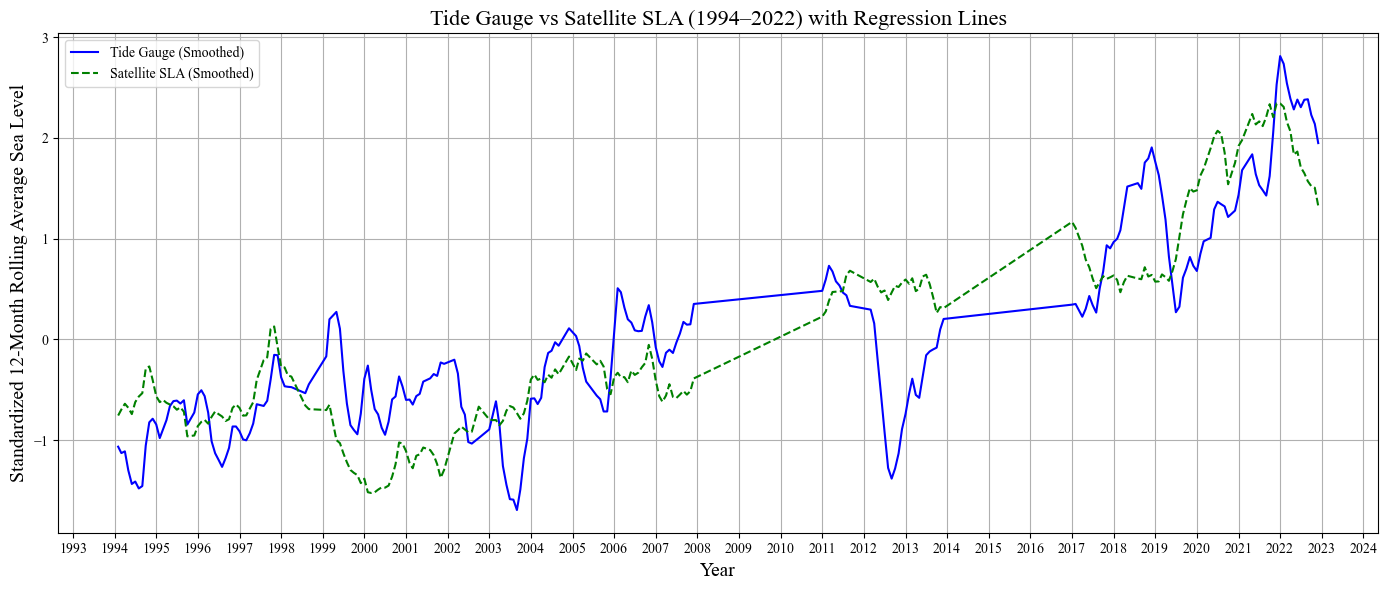

Correlation between Tide Gauge and Satellite SLA (1994–2022): 0.8006


In [25]:
"""THE DATA IS STANDARDIZED TO SCIENTIFICALLY COMPARE THE TREND"""

# Ensure datetime formats
df_tide['Tide_12Mon_MA'] = pd.to_datetime(df_tide['Tide_12Mon_MA'])
df_sat['SLA_12Mon_MA'] = pd.to_datetime(df_sat['SLA_12Mon_MA'])

# Filter both from 1994-01-01 to 2022-12-01
df_tide_filtered = df_tide[(df_tide['Tide_12Mon_MA'] >= '1994-01-01') & (df_tide['Tide_12Mon_MA'] <= '2022-12-01')]
df_sat_filtered = df_sat[(df_sat['SLA_12Mon_MA'] >= '1994-01-01') & (df_sat['SLA_12Mon_MA'] <= '2022-12-01')]

# Merge on the date (inner join to keep only common months)
df_merged = pd.merge(df_tide_filtered, df_sat_filtered, left_on='Tide_12Mon_MA', right_on='SLA_12Mon_MA', how='inner')

# Rename columns for clarity
df_merged = df_merged.rename(columns={
    'Tide_12Mon_MA': 'Date',
    'smoothed_x': 'Tide_Gauge_Smoothed',
    'smoothed_y': 'Satellite_Smoothed'
})

# Standardize both columns if needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_merged['Tide_Gauge_Smoothed'] = scaler.fit_transform(df_merged[['Tide_Gauge_Smoothed']])
df_merged['Satellite_Smoothed'] = scaler.fit_transform(df_merged[['Satellite_Smoothed']])

# Perform linear regression for both Tide and Satellite
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data
X = np.array(df_merged['Date'].map(lambda x: x.toordinal())).reshape(-1, 1)  # Convert dates to ordinal for regression
y_tide = df_merged['Tide_Gauge_Smoothed']
y_sat = df_merged['Satellite_Smoothed']

# Create linear regression models
reg_tide = LinearRegression().fit(X, y_tide)
reg_sat = LinearRegression().fit(X, y_sat)

# Get the regression lines
y_tide_reg = reg_tide.predict(X)
y_sat_reg = reg_sat.predict(X)

# Plotting
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(14, 6))
plt.plot(df_merged['Date'], df_merged['Tide_Gauge_Smoothed'], label='Tide Gauge (Smoothed)', color='blue', linestyle='-')
plt.plot(df_merged['Date'], df_merged['Satellite_Smoothed'], label='Satellite SLA (Smoothed)', color='green', linestyle='--')

# # Plot regression lines
# plt.plot(df_merged['Date'], y_tide_reg, label='Tide Gauge Regression Line', color='blue', linestyle='-', linewidth=2)
# plt.plot(df_merged['Date'], y_sat_reg, label='Satellite SLA Regression Line', color='green', linestyle='--', linewidth=2)

# Format x-axis for 2-year intervals
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Tide Gauge vs Satellite SLA (1994–2022) with Regression Lines', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Standardized 12-Month Rolling Average Sea Level', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
correlation = df_merged[['Tide_Gauge_Smoothed', 'Satellite_Smoothed']].corr().iloc[0, 1]
print(f"Correlation between Tide Gauge and Satellite SLA (1994–2022): {correlation:.4f}")


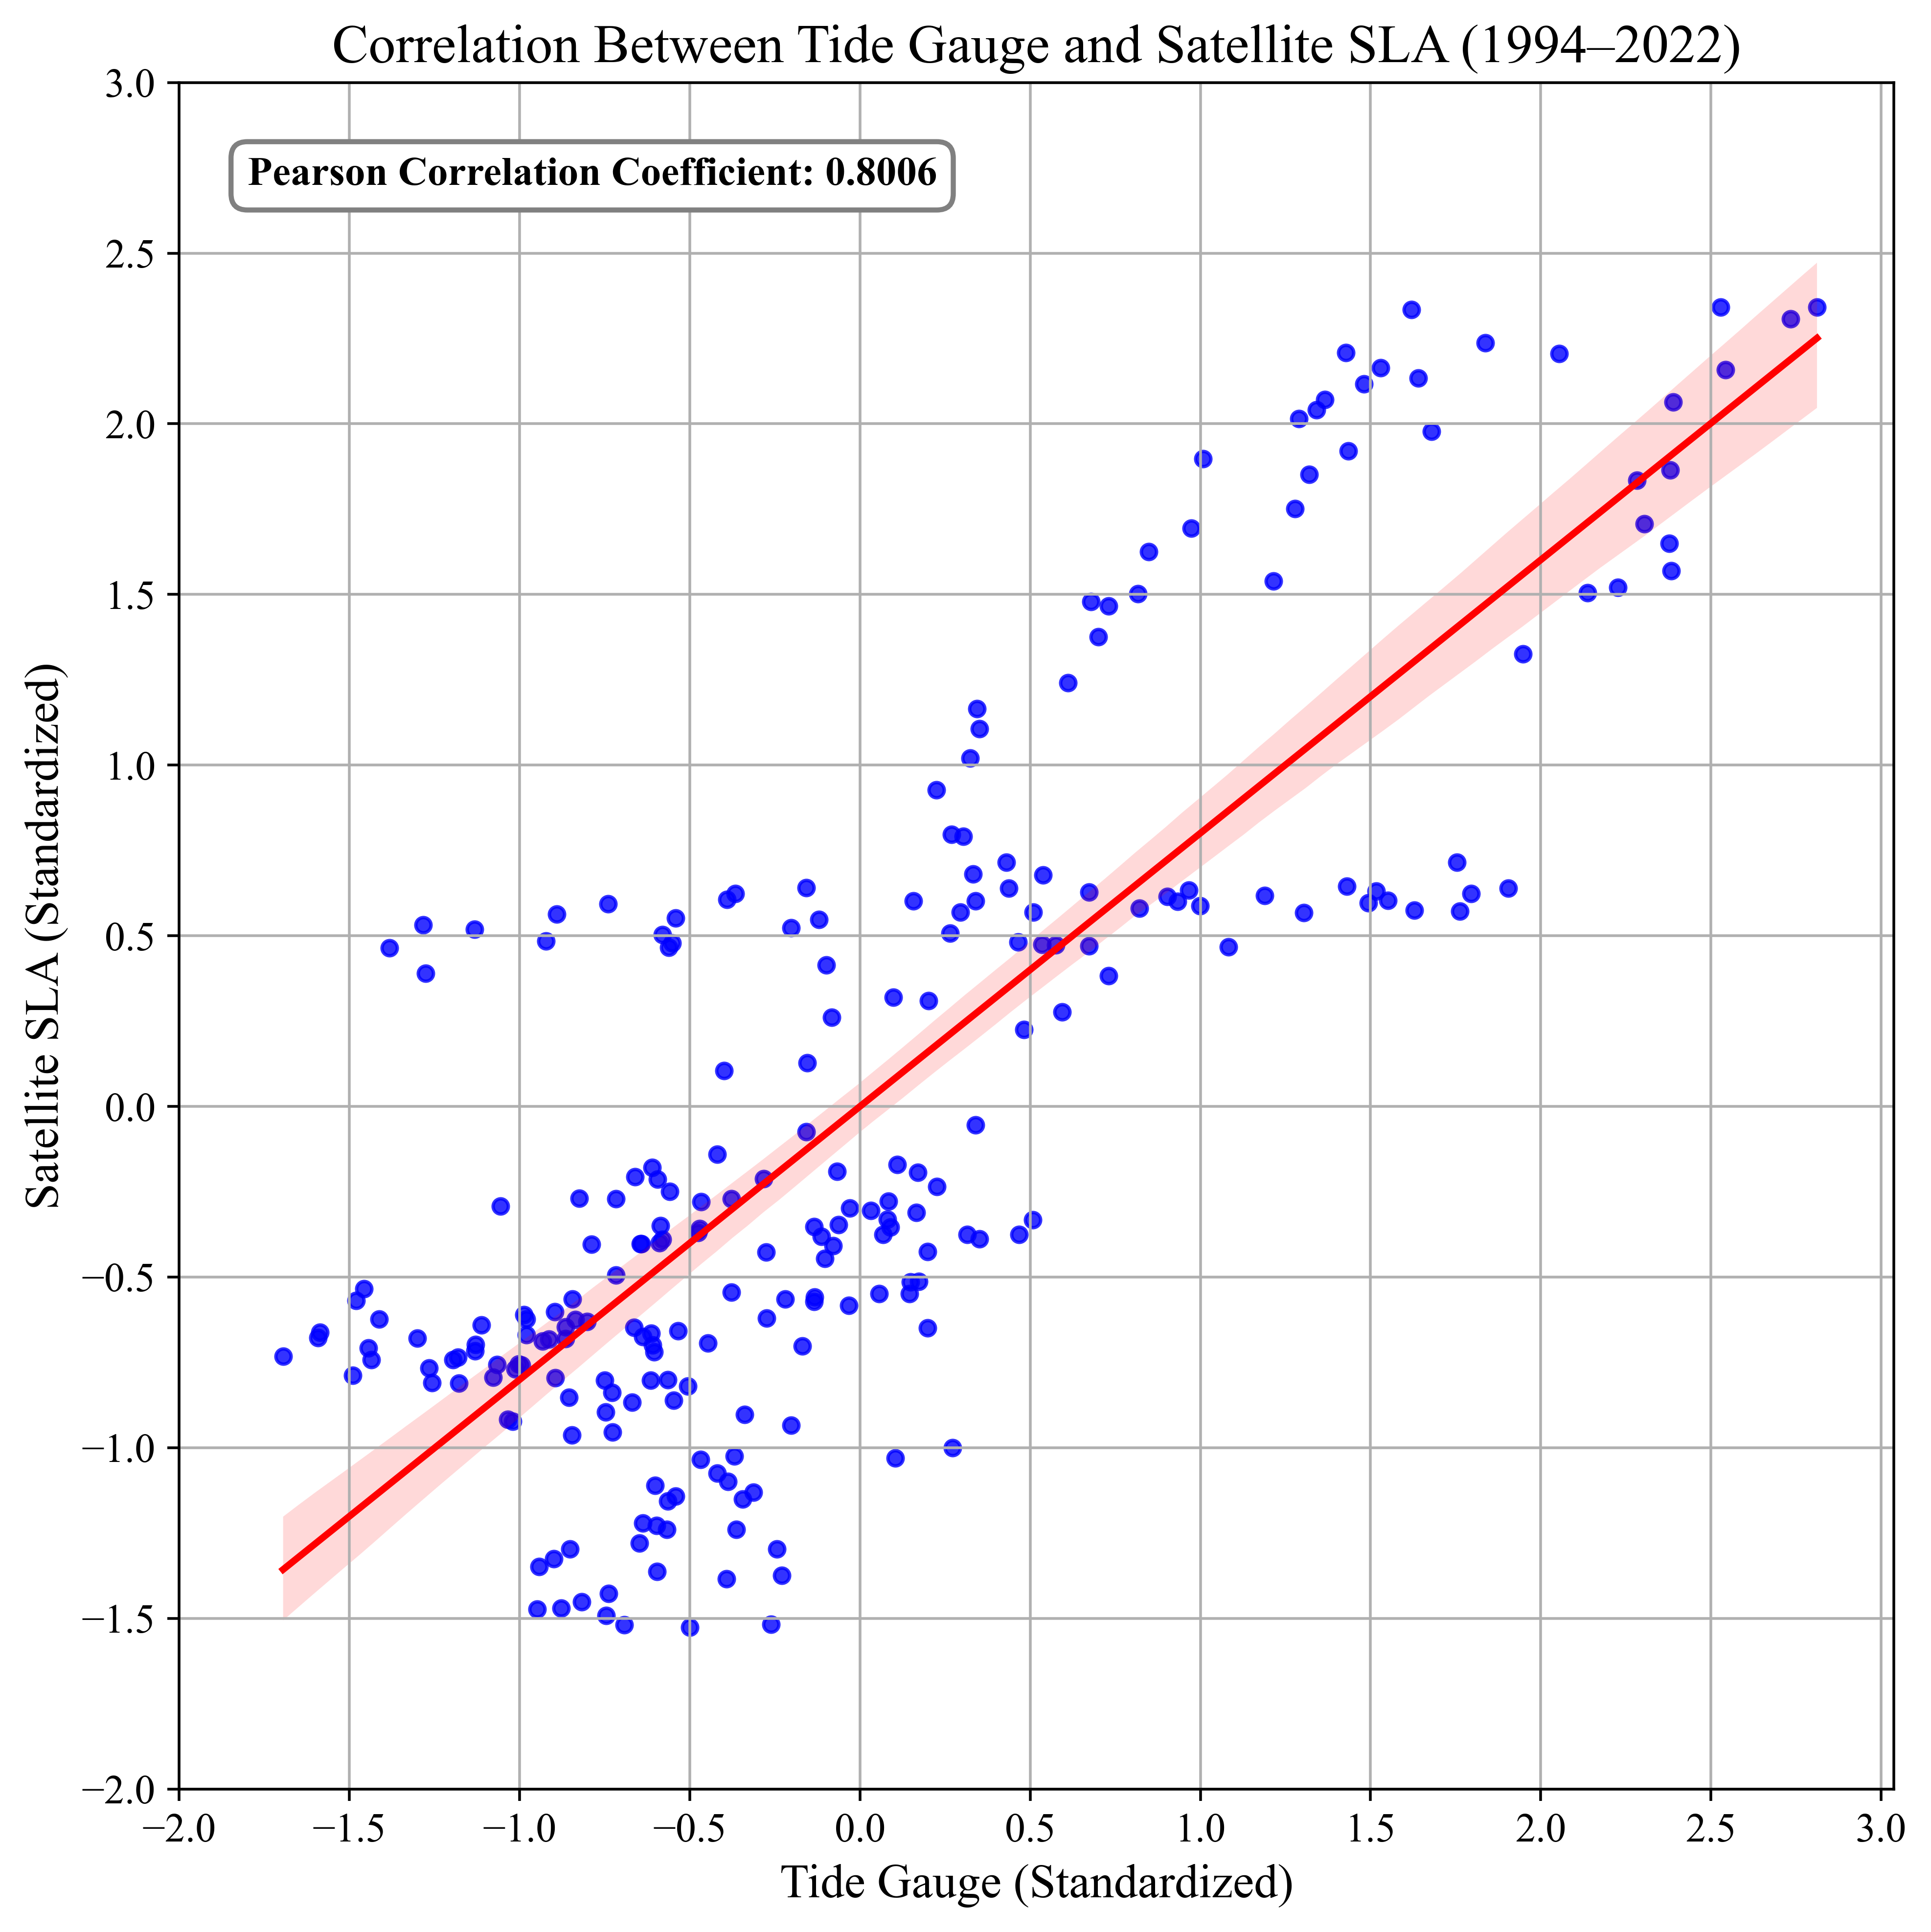

In [12]:
# Create the plot with the correlation line
plt.figure(figsize=(8, 8), dpi=500)

sns.regplot(x='Tide_Gauge_Smoothed', y='Satellite_Smoothed', data=df_merged, 
            scatter_kws={'s': 20, 'color': 'blue'}, line_kws={'color': 'red', 'lw': 2})

# Correlation coefficient
correlation = df_merged[['Tide_Gauge_Smoothed', 'Satellite_Smoothed']].corr().iloc[0, 1]

# Adding the Pearson correlation coefficient in a 3D-like white box
plt.text(-1.8, 2.7, f'Pearson Correlation Coefficient: {correlation:.4f}',
         fontsize=12, fontweight='bold', family='Times New Roman', color='black',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', linewidth=1.5))

# Title and axis labels
plt.title('Correlation Between Tide Gauge and Satellite SLA (1994–2022)', fontsize=16, family='Times New Roman')
plt.xlabel('Tide Gauge (Standardized)', fontsize=14, family='Times New Roman')
plt.ylabel('Satellite SLA (Standardized)', fontsize=14, family='Times New Roman')

# Set custom ticks
plt.xticks(np.arange(-2, 3.1, 0.5), family='Times New Roman', fontsize=12)
plt.yticks(np.arange(-2, 3.1, 0.5), family='Times New Roman', fontsize=12)

# Final touches
plt.grid(True)
plt.tight_layout()
plt.show()


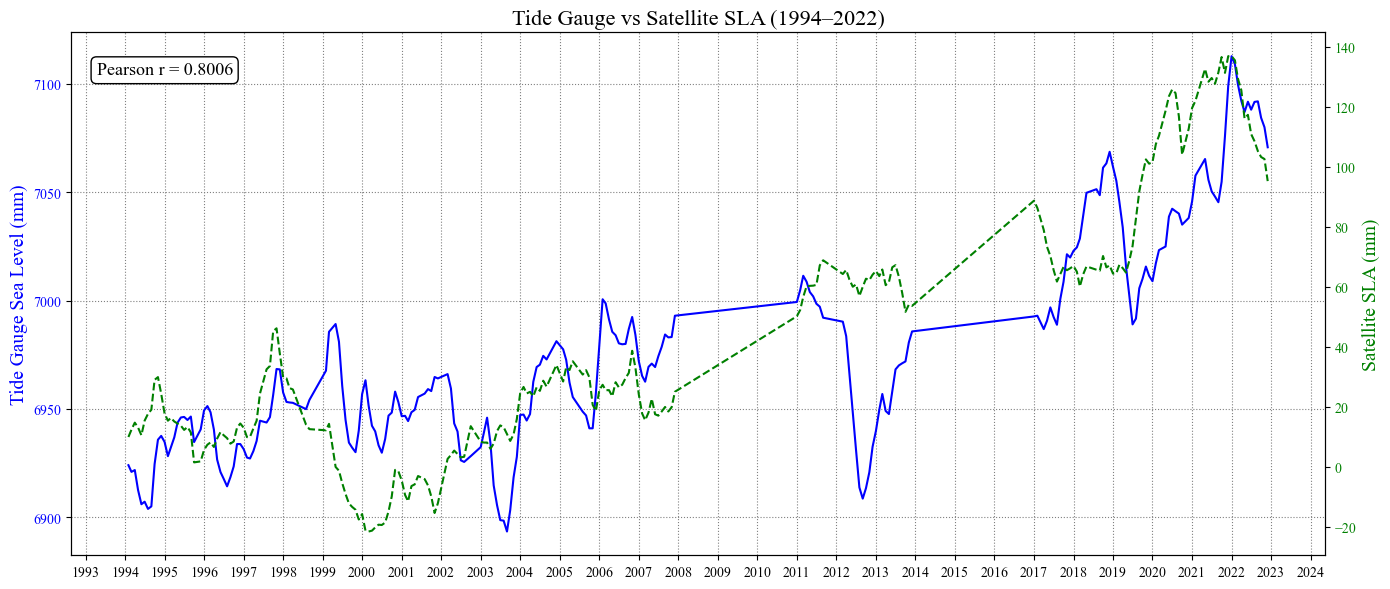

In [21]:
"""THE DATA IS UNSTANDARDIZED TO SCIENTIFICALLY COMPARE THE TREND"""

# Assuming df_merged already has the original (unstandardized) data
# You may want to re-merge without standardizing
df_unstd = pd.merge(df_tide_filtered, df_sat_filtered,
                    left_on='Tide_12Mon_MA',
                    right_on='SLA_12Mon_MA',
                    how='inner')

df_unstd = df_unstd.rename(columns={
    'Tide_12Mon_MA': 'Date',
    'smoothed_x': 'Tide_Gauge_Smoothed',
    'smoothed_y': 'Satellite_Smoothed'
})

# Calculate Pearson correlation (4 decimal places)
correlation = df_unstd[['Tide_Gauge_Smoothed', 'Satellite_Smoothed']].corr().iloc[0, 1]

# Plotting
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Tide Gauge data on left y-axis
ax1.plot(df_unstd['Date'], df_unstd['Tide_Gauge_Smoothed'], color='blue', label='Tide Gauge (Smoothed)', linestyle='-')
ax1.set_ylabel('Tide Gauge Sea Level (mm)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis with 1-year intervals
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Plot Satellite data on right y-axis
ax2 = ax1.twinx()
ax2.plot(df_unstd['Date'], df_unstd['Satellite_Smoothed'], color='green', label='Satellite SLA (Smoothed)', linestyle='--')
ax2.set_ylabel('Satellite SLA (mm)', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Enable both horizontal and vertical grid lines
ax1.grid(True, which='major', axis='both', linestyle=':', color='gray', linewidth=0.8)

# Annotate Pearson correlation
ax1.text(0.02, 0.92, f'Pearson r = {correlation:.4f}', transform=ax1.transAxes, fontsize=13,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Title and layout
plt.title('Tide Gauge vs Satellite SLA (1994–2022)', fontsize=16)
fig.tight_layout()
plt.show()


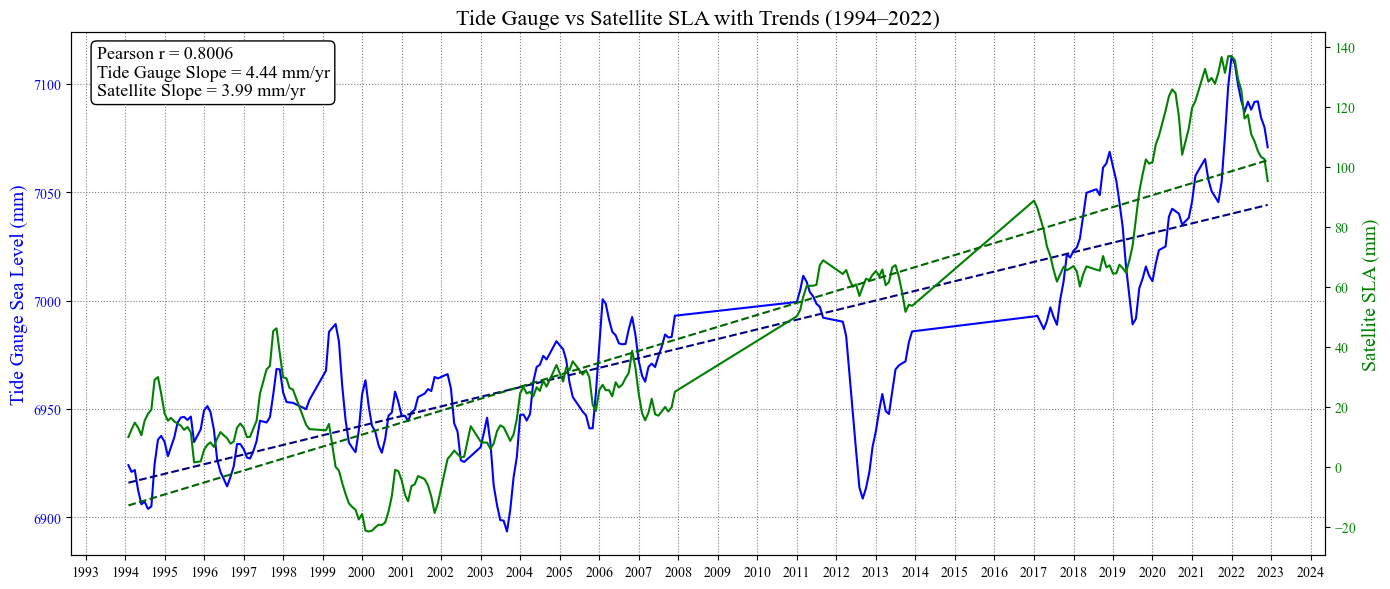

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.linear_model import LinearRegression

# Convert dates to numerical format for regression
x_num = mdates.date2num(df_unstd['Date']).reshape(-1, 1)

# Tide Gauge Regression
model_tide = LinearRegression().fit(x_num, df_unstd['Tide_Gauge_Smoothed'])
tide_pred = model_tide.predict(x_num)
tide_slope = model_tide.coef_[0] * 365  # mm/year

# Satellite Regression
model_sat = LinearRegression().fit(x_num, df_unstd['Satellite_Smoothed'])
sat_pred = model_sat.predict(x_num)
sat_slope = model_sat.coef_[0] * 365  # mm/year

# Pearson correlation
correlation = df_unstd[['Tide_Gauge_Smoothed', 'Satellite_Smoothed']].corr().iloc[0, 1]

# Plotting
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Tide Gauge + Regression
ax1.plot(df_unstd['Date'], df_unstd['Tide_Gauge_Smoothed'], color='blue', label='Tide Gauge (Smoothed)', linestyle='-')
ax1.plot(df_unstd['Date'], tide_pred, color='navy', linestyle='--', label='Tide Gauge Trend')
ax1.set_ylabel('Tide Gauge Sea Level (mm)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Format x-axis with 1-year intervals
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Plot Satellite + Regression
ax2 = ax1.twinx()
ax2.plot(df_unstd['Date'], df_unstd['Satellite_Smoothed'], color='green', label='Satellite SLA (Smoothed)', linestyle='-')
ax2.plot(df_unstd['Date'], sat_pred, color='darkgreen', linestyle='--', label='Satellite Trend')
ax2.set_ylabel('Satellite SLA (mm)', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Enable full grid
ax1.grid(True, which='major', axis='both', linestyle=':', color='gray', linewidth=0.8)

# Annotate Pearson r and slopes
info_text = (
    f"Pearson r = {correlation:.4f}\n"
    f"Tide Gauge Slope = {tide_slope:.2f} mm/yr\n"
    f"Satellite Slope = {sat_slope:.2f} mm/yr"
)
ax1.text(0.02, 0.88, info_text, transform=ax1.transAxes, fontsize=13,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Title and layout
plt.title('Tide Gauge vs Satellite SLA with Trends (1994–2022)', fontsize=16)
fig.tight_layout()
plt.show()


In [30]:
# Optional Step: Take monthly mean before further processing
df_sla['Month_Start'] = df_sla['time'].dt.to_period('M').dt.to_timestamp()
df_sla = df_sla.groupby('Month_Start')['sla'].mean().reset_index()
df_sla.rename(columns={'Month_Start': 'time'}, inplace=True)

# Convert SLA from meters to mm
df_sla['sla_mm'] = df_sla['sla'] * 1000

# Add time components
df_sla['time'] = pd.to_datetime(df_sla['time'])
df_sla['Month'] = df_sla['time'].dt.month_name()
df_sla['Year'] = df_sla['time'].dt.year
df_sla['Year-Month'] = pd.to_datetime(df_sla['Year'].astype(str) + '-' + df_sla['Month'], errors='coerce')

# Smooth the data using rolling average
df_sla['smoothed'] = df_sla['sla_mm'].rolling(window=12).mean()

# Remove NaNs
df_filtered = df_sla.dropna(subset=['Year-Month', 'smoothed'])
df_filtered = df_filtered[~df_filtered['smoothed'].isin([float('inf'), float('-inf')])]

# Now create the 'Year-Month-numeric' column after filtering
df_filtered['Year-Month-numeric'] = df_filtered['Year-Month'].dt.strftime('%Y').astype(int)

# Linear regression on smoothed data
X = df_filtered['Year-Month-numeric'].values.reshape(-1, 1)  # Use filtered Year-Month for regression
y = df_filtered['smoothed'].values  # Use the smoothed data for y

linear_model = LinearRegression()
linear_model.fit(X, y)
linear_slope = linear_model.coef_[0]
linear_intercept = linear_model.intercept_
y_pred_linear = linear_model.predict(X)

# Plot
plt.figure(figsize=(15, 7), dpi=700)
sns.lineplot(data=df_sla, x='Year-Month', y='sla_mm', color='darkgrey', label='Mean Monthly SLA', linewidth=1.5)
sns.lineplot(data=df_filtered, x='Year-Month', y='smoothed', color='b', label='Smoothed SLA (12-mo Avg)', linewidth=2)
plt.plot(df_filtered['Year-Month'], y_pred_linear, label=f'Linear Fit: {linear_slope:.2f} mm/year', color='orange')

# Axis formatting
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Sea Level Anomaly (mm)', fontsize=14)
plt.title('Monthly Sea Level Anomaly (Satellite) with Linear Regression Fit on Smoothed Data', fontsize=15)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Print linear regression slope
print(f"Linear Regression Slope (on Smoothed Data): {linear_slope:.2f} mm/year")


Linear Regression Slope (on Smoothed Data): 4.15 mm/year
